In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline

## Классификации текстов набора данных RuTweetCorp на два класса эмоциональной окраски

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install pytorch-transformers

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText

fatal: destination path 'fastText' already exists and is not an empty directory.
/content/gdrive/My Drive/Отбор на работу/Платформа НТИ/solution/fastText


In [ ]:
!sudo pip install .
%cd ../

Processing /content/gdrive/My Drive/Отбор на работу/Платформа НТИ/solution/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3009879 sha256=cbdfe36c122568a2c9fdbeb247121b5f6513590f68fc81b88e7ee4d52f0fbf62
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8cofjgd/wheels/b3/71/79/c90b23d1608bd152b6af6215920b1f4e9f31f6811a03947d14
Successfully built fasttext
  Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2
/content/gdrive/My Drive/Отбор на работу/Платформа НТИ/solution


In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import torch

import string
import re

from tqdm import tqdm, trange, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import random
import pymorphy2

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification, WarmupLinearSchedule
from tqdm import tqdm, trange, tqdm_notebook
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

Using TensorFlow backend.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


#### Зафиксируем seed для воспроизводимости

In [ ]:
#фиксируем seed 
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

RANDOM_SEED = 1712
    
init_random_seed(value=RANDOM_SEED)

База данных и таблицы состоит из 12 столбцов. <br>

***Описание столбцов***:
 - **id**: уникальный номер сообщения в системе twitter;
 - **date**: дата публикации сообщения (твита);
 - **name**: имя пользователя, опубликовавшего сообщение;
 - **text**:  текст сообщения (твита);
 - **type**: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
 - **rep**: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
 - **rtw**: количество ретвитов к данному сообщению (количество копирований этого сообщения другими пользователями);
 - **faw**: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
 - **stcount**: число всех сообщений пользователя в сети twitter;
 - **foll**: количество фоловеров пользователя (тех людей, которые читают пользователя);
 - **frien**: количество друзей пользователя (те люди, которых читает пользователь);
 - **listcount**: количество листов-подписок в которые добавлен твиттер-пользователь.

In [ ]:
n_columns = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_pos = pd.read_csv('data/positive.csv', sep=';', names=n_columns)
data_neg = pd.read_csv('data/negative.csv', sep=';', names=n_columns)

In [ ]:
data_pos.head()

,id,date,name,text,type,rep,rtw,faw,stcount,foll,frien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [ ]:
data_neg.head()

,id,date,name,text,type,rep,rtw,faw,stcount,foll,frien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [ ]:
print('Количество положительных отзывов :',data_pos.shape[0],'| Процент :',data_pos.shape[0]/(data_pos.shape[0]+data_neg.shape[0]))
print('Количество отрицательных отзывов :',data_neg.shape[0],'| Процент :',data_neg.shape[0]/(data_pos.shape[0]+data_neg.shape[0]))

Количество положительных отзывов : 114911 | Процент : 0.5065863142209721
Количество отрицательных отзывов : 111923 | Процент : 0.49341368577902783


Нет смысла дополнительно балансировать выборку

###### Проверка дубликатов

In [ ]:
print(len(np.unique(data_pos['text'])),len(np.unique(data_pos['id'])))
print(len(np.unique(data_neg['text'])),len(np.unique(data_neg['id'])))

110396 114911
107044 111923


уберем дублирования

In [ ]:
data_pos = data_pos.drop_duplicates('text',keep='first')
data_neg = data_neg.drop_duplicates('text',keep='first')

In [ ]:
sentences = np.concatenate((data_pos['text'].values,data_neg['text'].values))
labels = [1] * data_pos.shape[0] + [0] * data_neg.shape[0]

##### Посмотрим на несколько примеров твитов для понимания реализации препроцессинга

In [ ]:
print('Positive\n')
for tweet in sentences[:30]:
    print(tweet)
    print(10*'__')
print(20*'***')

print('Negative\n')   
for tweet in sentences[-30:]:
    print(tweet)
    print(10*'__')

Positive

@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)
____________________
Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D
____________________
RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!
____________________
RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…
____________________
@irina_dyshkant Вот что значит страшилка :D
Но блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D
____________________
ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6
____________________
RT @SpoonLamer: Ох,900 :D ну это конечно же @twinkleAYO . Чтобы у нее было много друзей, ведь она такая мимими &lt;3
____________________
RT @veregijytaqo: У тебя есть ухажёр? Нет - мои уши не кто не жрёт :D
____________________
Поприветствуем моего нового читателя @Alexey1789 ;)
____________________
Те

Можно заметить следующее:
 - очень много пунктуации связаной со смайлами - выражение эмоций (это надо учитывать)
 - во многих твитах есть:
   - ссылки - их можно заменить на 1 общий токен, а можно оставить все с предобработкой (надо посмотреть на кол-во использования каждого уникального элемента)
   - никнеймы других участников - можно заменить на 1 общий токен, а можно оставить все с предобработкой (надо посмотреть на кол-во использования каждого уникального элемента)
   - уменьшить словарь и заменить неизвестные слова на UNK
   - экспрессивная пунктуация

##### Длина твитов в зависимости от эмоционального окраса

In [ ]:
neg_len = [len(line) for line in data_neg.text.values]
pos_len = [len(line) for line in data_pos.text.values]

print('length of negative tweets\n','min =',np.min(neg_len),'max =',np.max(neg_len),)
print('avg =',np.mean(neg_len),'median =',np.median(neg_len))
print()
print('length of positive tweets\n','min =',np.min(pos_len),'max =',np.max(pos_len),)
print('avg =',np.mean(pos_len),'median =',np.median(pos_len))

length of negative tweets
 min = 8 max = 189
avg = 76.44141661372893 median = 69.0

length of positive tweets
 min = 21 max = 179
avg = 84.67268741621074 median = 78.0


In [ ]:
print(data_neg.text.values[np.argmin(neg_len)],'\n',data_neg.text.values[np.argmax(neg_len)])
print()
print(data_pos.text.values[np.argmin(pos_len)],'\n',data_pos.text.values[np.argmax(pos_len)])

домооой  
 RT @miwubiguvone: &lt;span style="font-size: medium;"&gt;&lt;br /&gt;ХОЧ Я&amp;nbsp;Й&amp;nbsp;ПРОСИВ&amp;nbsp;НЕ&amp;nbsp;ДОДАВАТИ&amp;nbsp;ЦЕЙ&amp;nbsp;ЖУРНАЛ&amp;nbsp;(&lt;/span&gt;&lt;…

@anieverthen бабушка  
 @iero3110 аах я уже домой дотопал..и теперь пойду спааать...спокойной ночи любимый фрончиииик:************** &lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3&lt;3


##### Препроцессинг

In [ ]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [ ]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [ ]:
mask_sad_d = dict()
mask_pos_d = dict()
for num, sentence in enumerate(sentences):
    if num == 10000:
        break
    
    mask_sad = re.findall('([>:;=-]+[\(cсCС/\\[L{<@]+)|([\(.]{2,})',sentence)
    mask_pos = re.findall('([>:;=-]+[\)dD*pPрРbB}]+)|([\)!]{2,})',sentence)

    if len(mask_sad)>0: 
        
        if mask_sad[0][0] == '':
            pass            
        elif mask_sad[0][0] in mask_sad_d:
            mask_sad_d[mask_sad[0][0]] += 1
        else:
            mask_sad_d[mask_sad[0][0]] = 1
        
        
        if mask_sad[0][1] == '':
            pass            
        elif len(mask_sad[0])>1 and mask_sad[0][1] in mask_sad_d:
            mask_sad_d[mask_sad[0][1]] += 1
        elif len(mask_sad[0])>1:
            mask_sad_d[mask_sad[0][1]] = 1
        
        
    elif len(mask_pos)>0: 
        
        if mask_pos[0][0] == '':
            pass
        if mask_pos[0][0] in mask_pos_d:
            mask_pos_d[mask_pos[0][0]] += 1
        else:
            mask_pos_d[mask_pos[0][0]] = 1
        
        
        if mask_pos[0][1] == '':
            pass        
        elif len(mask_pos[0])>1 and mask_pos[0][1] in mask_pos_d:
            mask_pos_d[mask_pos[0][1]] += 1
        elif len(mask_pos[0])>1:
            mask_pos_d[mask_pos[0][1]] = 1

##### Примеры смайлов

In [ ]:
mask_sad_d

{'-C': 1,
 '-c': 2,
 '-С': 5,
 '-с': 30,
 '..': 322,
 '...': 601,
 '....': 91,
 '.....': 20,
 '......': 12,
 '.......': 3,
 '........': 2,
 '...........': 1,
 '.............': 1,
 '..............': 1,
 ':/': 5,
 '://': 1639,
 ':@': 1,
 ':С': 3,
 ':СС': 1,
 ':с': 10,
 ':сс': 1,
 ';L': 1,
 ';с': 2,
 '=/': 1}

In [ ]:
del mask_pos_d['']
mask_pos_d

{'!!': 56,
 '!!!': 84,
 '!!!!': 21,
 '!!!!!': 5,
 '!!!!!!!': 3,
 '!!!!!!!!!': 1,
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!': 1,
 '!!!!!!!!!)))))': 1,
 '!!!!!))': 1,
 '!!!!!)))': 1,
 '!!!!)': 4,
 '!!!!)))': 3,
 '!!!!))))': 2,
 '!!!!)))))': 2,
 '!!!)': 4,
 '!!!))': 2,
 '!!!)))': 6,
 '!!!))))': 4,
 '!!!))))))': 1,
 '!!)': 5,
 '!!))': 4,
 '!!)))': 5,
 '!!)))))))': 1,
 '!)': 145,
 '!))': 32,
 '!)))': 31,
 '!))))': 9,
 '!)))))': 1,
 '!))))))': 1,
 '!)))))))))))))))': 1,
 ')!': 5,
 ')!)!))!': 1,
 '))': 857,
 ')))': 479,
 '))))': 110,
 ')))))': 42,
 '))))))': 13,
 ')))))))': 11,
 '))))))))': 8,
 ')))))))))': 3,
 '))))))))))': 5,
 ')))))))))))': 1,
 '))))))))))))': 1,
 ')))))))))))))': 2,
 '))))))))))))))': 1,
 ')))))))))))))))': 2,
 '))))))))))))))))))': 2,
 ')))))))))))))))))))': 2,
 '))))))))))))))))))))))': 1,
 '))))))))))))))))))))))))))': 1,
 ')))))))))))))))))))))))))))))': 1,
 '))))))))))))))))))))))))))))))': 1,
 '))))))))))))))))))))))))))))))))))))))))))))))': 1,
 ')))))))))))

Учёт экспрессивной пунктуации (подряд несколько точек, восклицательных знаков), ухудшает решение примерно на 1 процент на валидации и тесте.

Аналогично при учете различных emoji.

In [ ]:
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text,with_lemmatiz=False):
    # приведение к нижнему регистру
    text = text.lower().replace("ё", "е")
    # заменяем web-адреса на общий токен
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'URL', text)
    text = re.sub(r'http\S+', 'URL', text)
    # заменяем никнеймы на общий токен
    text = re.sub('@[^\s]+', 'USER', text)
    # заменяем тэги на общий токен
    text = re.sub('#[^\s]+', 'HASHTAG', text)
    # заменяем грустные смайлики на общий токен
    text = re.sub('([>:;=-]+[\(cсCС/\\[L{<@]+)|([\(]{2,})', ' BADSMILE ', text)
    # заменяем веселые/радостные смайлики на общий токен
    text = re.sub('([>:;=-]+[\)dD*pPрРbB]+)|([\)]{2,})', ' POSSMILE ', text)
    
    # убираем пунктуацию (стоп-слова уберем засчёт ограничения частоты в TF-IDF)
    text = re.sub('[^a-zA-Zа-яА-Я0-9]+', ' ', text)
    
    # убираем emoji
    text = re.sub(emoji_pattern, '', text)
    
    if with_lemmatiz:
        # лемматизация
        text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    return text.strip()

data_with_lem = [preprocess_text(t,with_lemmatiz=True) for t in tqdm_notebook(sentences)]

In [ ]:
data = data_with_lem.copy()

###### Примеры препроцессинга

In [ ]:
key = 8
sentences[key]

'Поприветствуем моего нового читателя @Alexey1789 ;)'

In [ ]:
data[key]

'поприветствовать мой новое читатель user possmile'

In [ ]:
for sent,post_sent in  zip(sentences[0:10],data[0:10]):
    print(sent)
    print('---')
    print(post_sent)
    print(20*"__")

@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)
---
user хоть я и школотый но поверь у мы то же самый possmile общество профилировать предмет тип
________________________________________
Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D
---
да весь таки он немного похожий на он но мой мальчик весь равно хороший possmile
________________________________________
RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!
---
rt user ну ты идиотка я испугаться за ты
________________________________________
RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…
---
rt user кто то в угол сидеть и погибать от голод а мы ещё 2 порция взять хотя уже и так жрать не хотеть possmile url
________________________________________
@irina_dyshkant Вот что значит страшилка :D
Но блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-

##### Сравним даёт ли улучшение замены смайлов и тэгов на общие токены 

In [ ]:
def preprocess_text_old(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я0-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data_old = [preprocess_text_old(t) for t in sentences]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
x_train_old, x_test_old, y_train_old, y_test_old = train_test_split(data_old, labels, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
print(len(x_train), len(x_test))

173952 43488


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
x_train_old, x_val_old, y_train_old, y_val_old = train_test_split(x_train_old, y_train_old, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
print(len(x_train), len(x_val))

139161 34791


### Baseline

###### Logistic Regression  

In [ ]:
cnt_vectorizer = CountVectorizer(ngram_range=(1,3))
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,3))

cnt_vectorizer_old = CountVectorizer(ngram_range=(1,3))
tf_idf_vectorizer_old = TfidfVectorizer(ngram_range=(1,3))

In [ ]:
X_train_tfidf = tf_idf_vectorizer.fit_transform(x_train)
X_val_tfidf = tf_idf_vectorizer.transform(x_val)
X_test_tfidf = tf_idf_vectorizer.transform(x_test)

X_train_cv = cnt_vectorizer.fit_transform(x_train)
X_val_cv = cnt_vectorizer.transform(x_val)
X_test_cv = cnt_vectorizer.transform(x_test)

In [ ]:
X_train_tfidf_old = tf_idf_vectorizer_old.fit_transform(x_train_old)
X_val_tfidf_old = tf_idf_vectorizer_old.transform(x_val_old)
X_test_tfidf_old = tf_idf_vectorizer_old.transform(x_test_old)

X_train_cv_old = cnt_vectorizer_old.fit_transform(x_train_old)
X_val_cv_old = cnt_vectorizer_old.transform(x_val_old)
X_test_cv_old = cnt_vectorizer_old.transform(x_test_old)

In [ ]:
%%time
tfidf_model =  LogisticRegression(C=20).fit(X_train_tfidf , y_train)

CPU times: user 42.1 s, sys: 22.6 s, total: 1min 4s
Wall time: 34.8 s


In [ ]:
%%time
cv_model =  LogisticRegression(C=20).fit(X_train_cv , y_train)

CPU times: user 39.8 s, sys: 20.8 s, total: 1min
Wall time: 32.8 s


In [ ]:
%%time
tfidf_model_old =  LogisticRegression(C=20).fit(X_train_tfidf_old, y_train_old)

CPU times: user 44.2 s, sys: 22.2 s, total: 1min 6s
Wall time: 36.3 s


In [ ]:
%%time
cv_model_old =  LogisticRegression(C=20).fit(X_train_cv_old , y_train_old)

CPU times: user 42.5 s, sys: 21.1 s, total: 1min 3s
Wall time: 35 s


In [ ]:
def score_tr_dev_test(model,model_name,x_train,x_val,x_test):
    print("Для модели",model_name)
    print("Train:",f1_score(y_train, model.predict(x_train),average='macro'),'|',"Val:",f1_score(y_val, model.predict(x_val),average='macro'),'|',"Test:",f1_score(y_test, model.predict(x_test),average='macro'))


In [ ]:
score_tr_dev_test(tfidf_model,'Log.Reg на TF-IDF',X_train_tfidf,X_val_tfidf,X_test_tfidf)
print()
score_tr_dev_test(cv_model,'Log.Reg на BoW',X_train_cv,X_val_cv,X_test_cv)

Для модели Log.Reg на TF-IDF
Train: 0.999611868033045 | Val: 0.9044585762258559 | Test: 0.9043375406075871

Для модели Log.Reg на BoW
Train: 0.9998490602240939 | Val: 0.9046415505981233 | Test: 0.9039733019578455


In [ ]:
score_tr_dev_test(tfidf_model_old,'Log.Reg на TF-IDF old',X_train_tfidf_old,X_val_tfidf_old,X_test_tfidf_old)
print()
score_tr_dev_test(cv_model_old,'Log.Reg на BoW old',X_train_cv_old,X_val_cv_old,X_test_cv_old)


Для модели Log.Reg на TF-IDF old
Train: 0.991568776327094 | Val: 0.7524822290645785 | Test: 0.7542649019352832

Для модели Log.Reg на BoW old
Train: 0.999281234861286 | Val: 0.7500652988294763 | Test: 0.7496222876353602


In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    plt.grid()
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=70, ha="right")

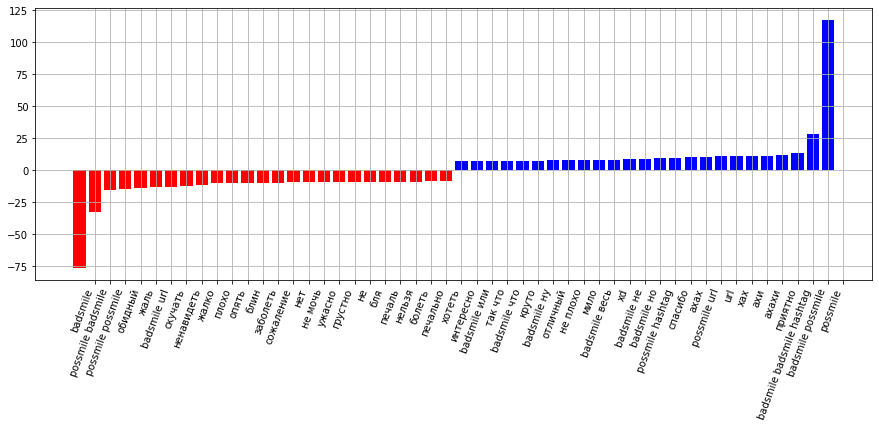

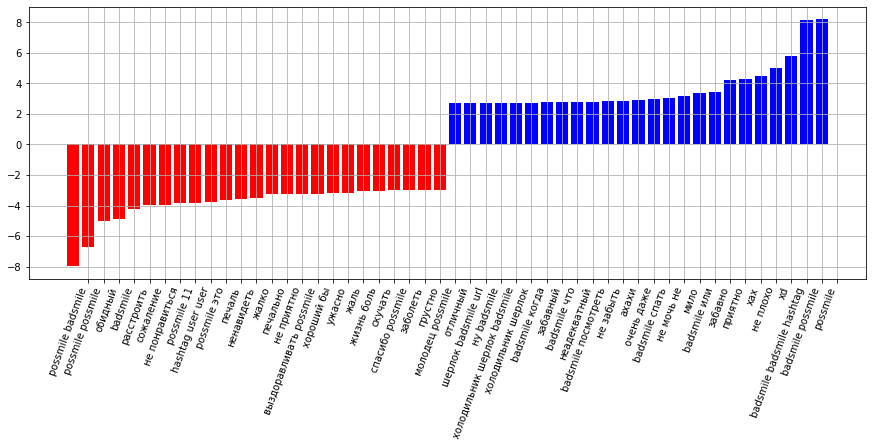

In [ ]:
visualize_coefficients(tfidf_model, tf_idf_vectorizer.get_feature_names())
visualize_coefficients(cv_model, cnt_vectorizer.get_feature_names())

###### Naive Bayess

In [ ]:
%%time
MND = MultinomialNB(alpha=1).fit(X_train_tfidf , y_train)

CPU times: user 187 ms, sys: 2.95 ms, total: 190 ms
Wall time: 189 ms


In [ ]:
%%time
BNB= BernoulliNB(alpha=1).fit(X_train_tfidf , y_train)

CPU times: user 206 ms, sys: 3.18 ms, total: 210 ms
Wall time: 210 ms


In [ ]:
score_tr_dev_test(MND,'MultinomialNB на TF-IDF',X_train_tfidf,X_val_tfidf,X_test_tfidf)
print()
score_tr_dev_test(BNB,'BernoulliNB на TF-IDF',X_train_tfidf,X_val_tfidf,X_test_tfidf)
print()
score_tr_dev_test(tfidf_model,'Log.Reg на TF-IDF',X_train_tfidf,X_val_tfidf,X_test_tfidf)
print()
score_tr_dev_test(cv_model,'Log.Reg на BoW',X_train_cv,X_val_cv,X_test_cv)

Для модели MultinomialNB на TF-IDF
Train: 0.9804723029105789 | Val: 0.8475782780882353 | Test: 0.8460808362193368

Для модели BernoulliNB на TF-IDF
Train: 0.9890103923626001 | Val: 0.8774394825487806 | Test: 0.8777637382989856

Для модели Log.Reg на TF-IDF
Train: 0.9991518563789901 | Val: 0.8940916338203637 | Test: 0.8957777147880494

Для модели Log.Reg на BoW
Train: 0.9998346850073411 | Val: 0.8916893612076922 | Test: 0.8942219217575517


**Использовал GridSearch для поиска наилучших параметров**

Возьмем как **baseline модель Log.Reg на TF-IDF**, у которой

Train: 0.9996 | Val: 0.9045 | Test: 0.9043

Причины, по которым рассматривал модель **Логистической регрессии и Наивный байесовский классификатор**, как базовые, тк:
 - обе модели быстро строятся и обучаются
 - есть вероятностная интерпретация выхода классификатора
 - можно проинтерпретировать веса признаков

### fastText classification

In [1]:
import fasttext

In [ ]:
def to_ft_format(sentences, labels, file_path):
    with open(file_path, 'w+', encoding="utf-8") as f:
        for sentence, label in zip(sentences, labels):
            label = "__label__"+str(label)
            f.write(label + " " + sentence + "\n")

In [ ]:
to_ft_format(x_train, y_train, 'data/data_lemmatize.train') #data/data_lemmatize
to_ft_format(x_val, y_val, 'data/data_lemmatize.val')
to_ft_format(x_test, y_test, 'data/data_lemmatize.test')


In [ ]:
fasttext_model = fasttext.train_supervised(input="data/data_lemmatize.train", epoch=50, lr=1.0, wordNgrams=2, dim=300)

In [ ]:
print(fasttext_model.test("data/data_lemmatize.val")) # epoch=50, lr=1.0, wordNgrams=2, dim=300
print(fasttext_model.test("data/data_lemmatize.test"))

(34791, 0.9014400275933431, 0.9014400275933431)
(43488, 0.9015820456217807, 0.9015820456217807)


In [6]:
%time
fasttext_model = fasttext.train_supervised(input="data/data.train", autotuneValidationFile='data/data_lemmatize.val')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [7]:
def f1(pr,rec):
    return 2*pr*rec/(pr+rec)

In [8]:
ft_res_train = fasttext_model.test("data/data.train") 
print(ft_res_train)  #autotuneValidationFile
print('f1 =',f1(ft_res_train[1],ft_res_train[2]))

ft_res_val = fasttext_model.test("data/data.val") 
print(ft_res_val)  #autotuneValidationFile
print('f1 =',f1(ft_res_val[1],ft_res_val[2]))

ft_res_test = fasttext_model.test("data/data.test") 
print(ft_res_test)
print('f1 =',f1(ft_res_test[1],ft_res_test[2]))

(145173, 0.922285824499046, 0.922285824499046)
f1 = 0.9222858244990458
(36294, 0.9082492974045296, 0.9082492974045296)
f1 = 0.9082492974045296
(45367, 0.9087662838627196, 0.9087662838627196)
f1 = 0.9087662838627196


In [9]:
fasttext_model.save_model("fasstText_autotune.bin")

Как видим в итоге **fastText** работает немного лучше, чем модель **Logistic Regression на TF-IDF** векторах.

Это логично, тк **fastText**:
 - учитывает локальную близость слов (чего нет в TF-IDF и BoW, где используется глобальная информация) 
 - обрабатывает  OOV (out of vocabluraly) слов, что положительно влияет при использовании алгоритма на новых данных.


### Fine-tuning BERT

Модель BERT показала  

Разбиваем предложения для BERT( для них не пользуемся никакой предобработкой, кроме добавления токенов разделения предложений)

In [ ]:
sentences_bert = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [ ]:
train_sentences, test_sentences, train_y, test_y = train_test_split(sentences_bert, labels, test_size=0.2,random_state=RANDOM_SEED)

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# base -model | uncased - все слова в нижнем регистре
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in train_sentences]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in test_sentences]
print(tokenized_texts_train[0])

['[CLS]', 'н', '##и', 'р', '##а', '##з', '##у', 'н', '##е', 'и', '##с', '##п', '##а', '##ч', '##ка', '##л', '##с', '##я', 'т', '##о', '##р', '##т', '##о', '##м', ')', ')', ')', 'http', ':', '/', '/', 't', '.', 'co', '/', 'j', '##y', '##ca', '##dt', '##xa', '##fb', '[SEP]']


In [ ]:
tokenized_texts_train[0]

['[CLS]',
 'н',
 '##и',
 'р',
 '##а',
 '##з',
 '##у',
 'н',
 '##е',
 'и',
 '##с',
 '##п',
 '##а',
 '##ч',
 '##ка',
 '##л',
 '##с',
 '##я',
 'т',
 '##о',
 '##р',
 '##т',
 '##о',
 '##м',
 ')',
 ')',
 ')',
 'http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'j',
 '##y',
 '##ca',
 '##dt',
 '##xa',
 '##fb',
 '[SEP]']

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

**Для начала обучим модель, которая либо обрезает часть твитов до 100 токенов, либо заполняет нулями пустые токены до длины 100.**

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
max([len(text) for text in tokenized_texts_train])

149

In [ ]:
input_ids.shape

(173952, 100)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_y, 
    random_state=RANDOM_SEED,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=RANDOM_SEED,
    test_size=0.2
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels.shape, validation_labels.shape

(torch.Size([139161]), torch.Size([34791]))

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size= 32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size= 32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:11<00:00, 38341924.63B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

max_grad_norm_clipping = 1

In [ ]:
len(train_dataloader)

4349

In [ ]:
def train(model, train_dataloader, optimizer, EPOCH_AMOUNT, with_clipping=False,max_grad_norm_clipping=1):
    # Будем сохранять loss во время обучения
    # и рисовать график в режиме реального времени
    train_loss_set = []
    train_loss = 0


    # Обучение
    # Переводим модель в training mode
    model.train()

    for _ in range(EPOCH_AMOUNT):
      for step, batch in enumerate(train_dataloader):
          # добавляем батч для вычисления на GPU
          batch = tuple(t.to(device) for t in batch)
          # Распаковываем данные из dataloader
          b_input_ids, b_input_mask, b_labels = batch
          
          # если не сделать .zero_grad(), градиенты будут накапливаться
          optimizer.zero_grad()
          
          # Forward pass
          loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

          train_loss_set.append(loss[0].item())  
          
          # Backward pass
          loss[0].backward()

          if with_clipping:
              # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm_clipping)
          
          # Обновляем параметры и делаем шаг используя посчитанные градиенты
          optimizer.step()

          # Обновляем loss
          train_loss += loss[0].item()
          
          # Рисуем график
          clear_output(True)
          plt.figure(figsize=(12, 6))
          plt.plot(train_loss_set)
          plt.title("Training loss")
          plt.xlabel("Batch")
          plt.ylabel("Loss")
          plt.grid()
          plt.show()
          
      print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
    

In [ ]:
def test(model, dataloader, name_dtlder='Test'):
    # Валидация
    # Переводим модель в evaluation mode
    model.eval()
    test_preds, test_labels = [], []

    for batch in tqdm_notebook(dataloader):
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для тестовых данных.
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Сохраняем предсказанные классы и ground truth
        batch_preds = np.argmax(logits, axis=1)

        if len(label_ids.shape) == 1:
           batch_labels = label_ids  
        else:
            batch_labels = np.concatenate(label_ids)
        test_preds.extend(batch_preds)
        test_labels.extend(batch_labels)
        batch_preds = np.argmax(logits, axis=1) 

    
    acc_score = accuracy_score(test_labels, test_preds)
    print('Процент правильных предсказаний на {0} выборке составил:  f1 = {1:.2f}%'.format(name_dtlder, f1_score(test_labels, test_preds, average='macro') * 100
    ))

    return test_preds, test_labels

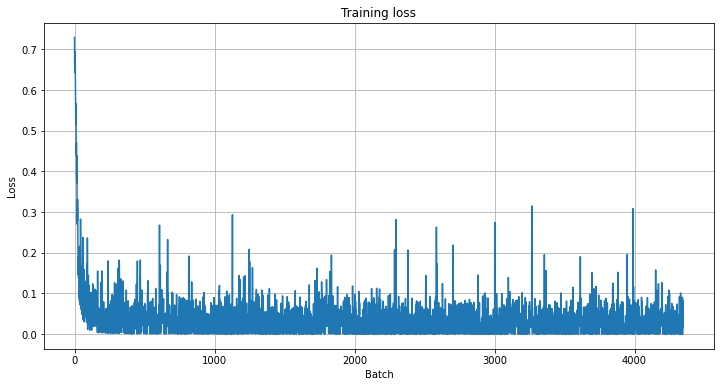

Loss на обучающей выборке: 0.03663


In [ ]:
train(model, train_dataloader, optimizer, 1)

In [ ]:
val_preds, val_labels = test(model, validation_dataloader, name_dtlder='VAl')


Процент правильных предсказаний на VAl выборке составил:  f1 = 98.16%


In [ ]:
 val_labels = np.array(val_labels)
 val_preds = np.array(val_preds)

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(val_labels != val_preds),
    len(val_labels)
))

Неправильных предсказаний: 640/34791


In [ ]:
# model_save_name = 'BERT-1epoch_new.ckpt'
model_save_name = 'BERT-1epoch_100.ckpt'
path = f'/content/gdrive/My Drive/Отбор на работу/Платформа НТИ/solution{model_save_name}'

In [ ]:
torch.save(model.state_dict(), path)
# model.load_state_dict(torch.load(path))

In [ ]:
del fasttext_model

In [ ]:
del X_train_tfidf,X_val_tfidf,X_test_tfidf, X_train_cv,X_val_cv,X_test_cv
del x_train_old, x_val_old, y_train_old, y_val_old, x_test_old, y_test_old
del tfidf_model, cv_model, tfidf_model_old, cv_model_old

# Оценка качества на отложенной выборке

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)
test_labels = torch.tensor(test_y)

test_data = TensorDataset(
    test_inputs,
    test_masks,
    test_labels
)

test_dataloader = DataLoader(
    test_data, 
    sampler=SequentialSampler(test_data),
    batch_size=32
)

In [ ]:
print(len(test_dataloader))
test_inputs.shape

1359


torch.Size([43488, 100])

In [ ]:
test_preds, test_labels = test(model, test_dataloader, name_dtlder='Test')


Процент правильных предсказаний на Test выборке составил:  f1 = 98.04%


In [ ]:
 test_labels = np.array(test_labels)
 test_preds = np.array(test_preds)

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(test_labels != test_preds),
    len(test_labels)
))

Неправильных предсказаний: 853/43488


In [ ]:
for num,key in enumerate(np.where(test_labels != test_preds)[0]): 
  if num == 10:
      break
  print(f'порядковый номер {key} | {test_sentences[key]} | True = {test_labels[key]} | Pred {test_preds[key]}')
  print(10*'-------')

порядковый номер 3 | [CLS] После таких выходных нужна неделя реабилитации. Алкоголь - зло, как ни крути. Отныне встречи со старыми друзьям исключают крепкие напитки) [SEP] | True = 1 | Pred 0
----------------------------------------------------------------------
порядковый номер 5 | [CLS] Google ... ажилд оролцоход ганцхан шалгуур бий - Ямар нэгэн ажил хариуцаж, ажлаа хугацаанд нь хариуцлагатай хийж дуусгадаг байх :) [SEP] | True = 1 | Pred 0
----------------------------------------------------------------------
порядковый номер 52 | [CLS] Спавшая 4 часа после пар планировала приехать домой и отдохнуть часик-2. Но такая погода!лучше пойду гули-гули на полчасика:) кто со мной? [SEP] | True = 1 | Pred 0
----------------------------------------------------------------------
порядковый номер 152 | [CLS] Ололо, на Первом канале рассказывают, как избирать "старшего по подъезду" и лишать его должности, если он не справляется) [SEP] | True = 1 | Pred 0
-----------------------------------------

Выводы:
 - BERT сразу выдаеёт (после 1 эпохи fine-tuning) хорошее качество

Это происходит, тк BERT токенизирует слова с помощью BPE и часть важной информации, которая помогает трансформеру хорошо повысить качество, не отбрасывается во время препроцессинга (как было в предыдущих моделях). Также эмбеддинги BERTа не только учитывают локальную близость, но и контекст в котором слово подразумевается.

**Теперь будем использовать максимальное кол-во токенов в 
эмбеддинге BERT равное максимальное длине слова в данных.**

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids = pad_sequences(
    input_ids,
    # maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
max([len(text) for text in tokenized_texts_train])

149

In [ ]:
input_ids.shape

(173952, 149)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_y, 
    random_state=RANDOM_SEED,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=RANDOM_SEED,
    test_size=0.2
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels.shape, validation_labels.shape

(torch.Size([139161]), torch.Size([34791]))

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size= 16
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size= 16
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

max_grad_norm_clipping = 1

In [ ]:
len(train_dataloader)

8698

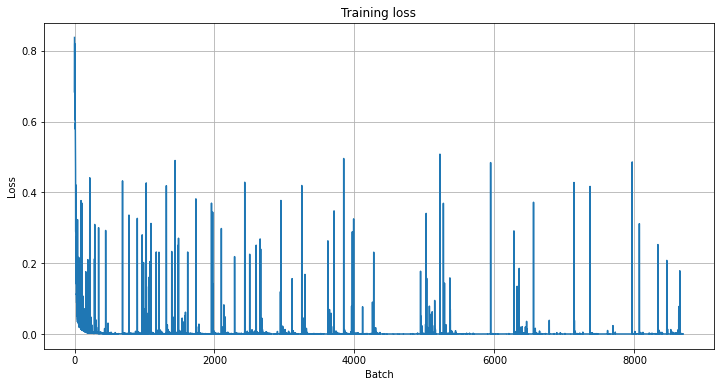

Loss на обучающей выборке: 0.00567


In [ ]:
train(model, train_dataloader, optimizer, 1)

In [ ]:
val_preds, val_labels = test(model, validation_dataloader, name_dtlder='VAl')


Процент правильных предсказаний на VAl выборке составил:  f1 = 99.93%


In [ ]:
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(val_labels != val_preds),
    len(val_labels)
))

Неправильных предсказаний: 25/34791


In [ ]:
# model_save_name = 'BERT-1epoch_new.ckpt'
model_save_name = 'BERT-1epoch_max.ckpt'
path = f'/content/gdrive/My Drive/Отбор на работу/Платформа НТИ/solution{model_save_name}'

In [ ]:
torch.save(model.state_dict(), path)
# model.load_state_dict(torch.load(path))

# Оценка качества на отложенной выборке

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

input_ids = pad_sequences(
    input_ids,
    # maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)
test_labels = torch.tensor(test_y)

test_data = TensorDataset(
    test_inputs,
    test_masks,
    test_labels
)

test_dataloader = DataLoader(
    test_data, 
    sampler=SequentialSampler(test_data),
    batch_size=16
)

In [ ]:
print(len(test_dataloader))
test_inputs.shape

2718


torch.Size([43488, 134])

In [ ]:
test_preds, test_labels = test(model, test_dataloader, name_dtlder='Test')


Процент правильных предсказаний на Test выборке составил:  f1 = 99.95%


In [ ]:
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(test_labels != test_preds),
    len(test_labels)
))

Неправильных предсказаний: 20/43488


In [ ]:
for num,key in enumerate(np.where(test_labels != test_preds)[0]): 
    if num == 30:
        break
    print(f'порядковый номер {key} | {test_sentences[key]} | True = {test_labels[key]} | Pred {test_preds[key]}')
    print(10*'-------')

порядковый номер 1395 | [CLS] RT @Horanso_on: @Stylinso_on именно для тибя #ПредновогодниеОбнимашки бро дай пятюню ^_° [SEP] | True = 0 | Pred 1
----------------------------------------------------------------------
порядковый номер 6940 | [CLS] RT @cokosapopuli: кстати,   , я ж обещал тогда рассказать про утекающую память в fcgi. так вот Object::Destroyer прекрасно расправляется со [SEP] | True = 1 | Pred 0
----------------------------------------------------------------------
порядковый номер 10504 | [CLS] RT @_Ko_oT_: Как же мне сегодняшний день понравился *000* [SEP] | True = 0 | Pred 1
----------------------------------------------------------------------
порядковый номер 11556 | [CLS] @Mo_OnMery мне немного Аято нравится и Раито ^^ [SEP] | True = 0 | Pred 1
----------------------------------------------------------------------
порядковый номер 15094 | [CLS] RT @sho_oni: А я так смотрю, Мыле нравится моя подборочка ^^ [SEP] | True = 0 | Pred 1
-------------------------------------

В итоге, наилучшем образом работает BERT с Fine-tuning. <br>
**Train: 99.99%| VAl: 99.93% | test: 99.95%**

Увеличение максимальной длины всей последовательности позволило модели оценивать весь текст твита и делать предсказание наилучшим образом. Однако каким образом назначить максимальную длину зависит от располагаемой GPU и времени ожидания.